In [1]:
import os
from math import ceil
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # if you need to view less rows, comment
# pd.set_option('display.max_rows', None)  # if you need to view more rows, uncomment
mean = 'mean'
std = 'std'
idx_slice = pd.IndexSlice

In [2]:
file_location = '/home/kmeador/SEC' # escher
# file_location = '/home/kylemeador' # powerpanda
file_name = '123021_T33_G8_F3_F9_450ul_strait_elution'

In [3]:
extension = 'csv'
analysis_file = os.path.join(file_location, '%s.%s' % (file_name, extension))

## Plotting Options

In [51]:
only_plot_A280 = True # False # 
overlap_chromatograms = False # True #  | Will take priority over stack figures, so if True, then regardless, the chromatograms will stack
stack_figures = True # False # 
plot_fractions = True # False # 
fraction_size = 0.5
fraction_start = 8.068
fraction_end = 25.0

## Check DataFrame columns and values

### for datasets that are exported with volumes for every measurement

In [5]:
volume_is_index = False
sec_data_df = pd.read_csv(analysis_file, header=[0,1])

### For datasets that are exported with normalized volumes (every measurement is indexed to the same volume)

In [6]:
volume_is_index = True
sec_data_df = pd.read_csv(analysis_file, header=[0,1], index_col=0)

In [7]:
sec_data_df.head()

T33_F3_450ul_strait_elution                   \
X_Axis_volume            UV1 (215 nm)_mAU UV3 (280 nm)_mAU   
-1.001290                             NaN              NaN   
-0.999878                      141.511011         1.041570   
-0.999063                      269.579849         1.984201   
-0.998038                      329.604000         2.426000   
-0.996921                      329.529011         2.427364   

              T33_F5_250ul_concentrated_elution                   \
X_Axis_volume                  UV1 (215 nm)_mAU UV3 (280 nm)_mAU   
-1.001290                              0.000000         0.000000   
-0.999878                            107.697003         0.000000   
-0.999063                            104.379957         3.178778   
-0.998038                            102.779001         4.713000   
-0.996921                            102.866591         4.710069   

              T33_F9_450ul_elution_concentrated                   \
X_Axis_volume                  UV1 (215 nm)_mAU UV3 (280 nm)_mAU   
-1.001290                                   NaN              NaN   
-0.999878                                   NaN              NaN   
-0.999063                                   NaN              NaN   
-0.998038                                   NaN              NaN   
-0.996921                                   NaN              NaN   

              T33_G8_450ul_strait_elution                   
X_Axis_volume            UV1 (215 nm)_mAU UV3 (280 nm)_mAU  
-1.001290                             NaN              NaN  
-0.999878                             NaN              NaN  
-0.999063                        0.000000              0.0  
-0.998038                       34.625001              0.0  
-0.996921                       34.625001              NaN

In [8]:
def split_biorad_chromatogram_dataframe_to_unique_runs(df):
    return [df.loc[:, idx_slice[run, :]] for run in df.columns.levels[0].to_list()]

In [9]:
# def extract_volume_and_uv_columns_from_biorad_chromatogram(df):
#     uv_columns = []
#     volume = None
#     for column in df.columns.levels[-1].to_list():
#         if column.startswith('UV'):
#             if column.endswith('_volume'):  # not volume and 
#                 volume = column
#             else:
#                 uv_columns.append(column)
#     return volume, uv_columns

In [10]:
sec_runs = split_biorad_chromatogram_dataframe_to_unique_runs(sec_data_df)
# chromatogram_graph_data = [extract_volume_and_uv_columns_from_biorad_chromatogram(run_df) for run_df in sec_runs]

In [11]:
# volume, uv_columns = chromatogram_graph_data[0]
# print(volume, uv_columns)

In [60]:
def plot_chromatograms(sec_runs, only_280=True, volume_is_column=False, 
                       stack_figures=False, overlap_chromatograms=False, annotate=True,
                       fractions=False, fraction_start=None, fraction_end=None, fraction_size=0.5):
    #     vol_idx, uv_idx = 0, 1
    figure_aspect_ratio = (15, 5)
    fig = plt.figure(figsize=figure_aspect_ratio)
    if overlap_chromatograms:
        axis = fig.subplots(1, 1, sharex=True)
        axes = [axis for _ in range(len(sec_runs))]
    elif stack_figures:
        figs = [plt.figure(figsize=figure_aspect_ratio) for _ in range(len(sec_runs))]
        axes = [fig.subplots(1, 1, sharex=True) for fig in figs]
    else:
        axes = fig.subplots(len(sec_runs), 1, sharex=True)

    for idx, run_df in enumerate(sec_runs):
        uv_columns = []
        volume = None
        for column in run_df.columns.levels[-1].to_list():
            if column.startswith('UV'):
                if column.endswith('_volume'):
                    volume = column
                elif only_280:
                    if '280 nm' in column:
                        uv_columns.append(column)
                    else:
                        continue
                else:
                    uv_columns.append(column)
                    

        if volume_is_column and volume:      
            selected_columns = [volume] + uv_columns
        else:
            selected_columns = uv_columns
        
#         volume, uv_columns = chromatogram_graph_data[idx] # [vol_idx], chromatogram_graph_data[idx][uv_idx]
        run_df.columns = run_df.columns.remove_unused_levels()  # .unique()
        df_name = run_df.columns.levels[0][0]  # level zero, label zero
        formatted_df = run_df.loc[:, idx_slice[:, selected_columns]].droplevel(0, axis=1)
        # grab first level, first (and only index)
        # df_title = run_df.columns.levels[0].unique()  # Doesn't work as grabs old levels from original DF
        df_title = run_df.columns.get_level_values(0).unique()
        if len(df_title) != 1:
            print('Error, multiple headers detected in dataframe %s!\n%s' % (df_title, run_df.head()))
            break
        # formatted_df = formatted_df[formatted_df[volume] > 0.007]
        # format the volume as the dependent variable
        if volume_is_column:      
            formatted_df.index = formatted_df[volume]
            formatted_df.drop(volume, axis=1, inplace=True)
        formatted_df.index.name = 'Volume'
        
        # format column names to be pretty
        formatted_df.columns = formatted_df.columns.map(dict(zip(formatted_df.columns, 
            map(str.strip, 
                map(str.strip, 
                    map(str.replace, 
                        map(str.replace, formatted_df.columns, repeat('_mAU'), repeat('')),
                        repeat('UV'), repeat('')), 
                    repeat('1234567890 ')), 
                repeat('()')))))
#         formatted_df.plot(title=df_title[0])
        axes[idx].plot(formatted_df.index.values, formatted_df.values, label=df_name) # formatted_df.columns)
        axes[idx].legend()
        axes[idx].set_xlim(0, None)
        if fractions:
            if not annotate:
                continue
            if not fraction_start:
                fraction_start = 0.
            if not fraction_end:
                fraction_end = formatted_df.index[-1]
            number_of_fractions = (fraction_end - fraction_start) / fraction_size
            fraction_start_volumes = [fraction_start + (fraction_size * fraction) for fraction in range(ceil(number_of_fractions))]
            axes[idx].vlines(fraction_start_volumes, 0, 1, transform=axes[idx].get_xaxis_transform(), label='Fractions', colors=['#cccccc' if idx % 2 == 1 else '#000eee' for idx, _ in enumerate(fraction_start_volumes)])
            max_height = formatted_df.max()
            for f_idx, volume in enumerate(fraction_start_volumes, 1):
#                 axes[idx].annotate(f_idx, xy=(volume, max_height),
                axes[idx].annotate(f_idx, xy=(volume, 1),  xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction') , # xycoords=axes[idx], textcoords=axes[idx],  #   # xytext=(-3, np.sign(l)*3),
                                   horizontalalignment='left', verticalalignment='top')
#                 matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
            if overlap_chromatograms:
                annotate = False
#         if stack_figures:
#             plt.show()
#     if not stack_figures:
    plt.show()

<Figure size 1500x500 with 0 Axes>

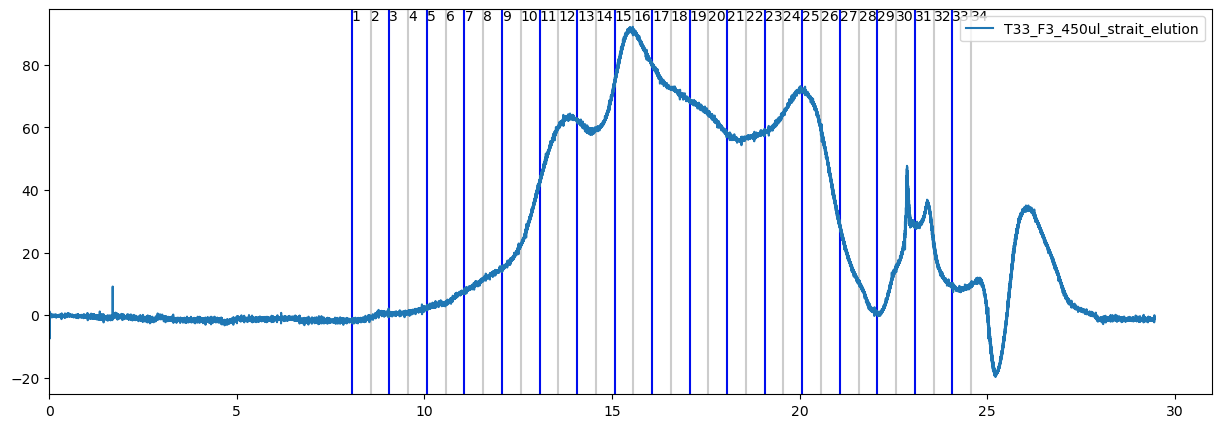

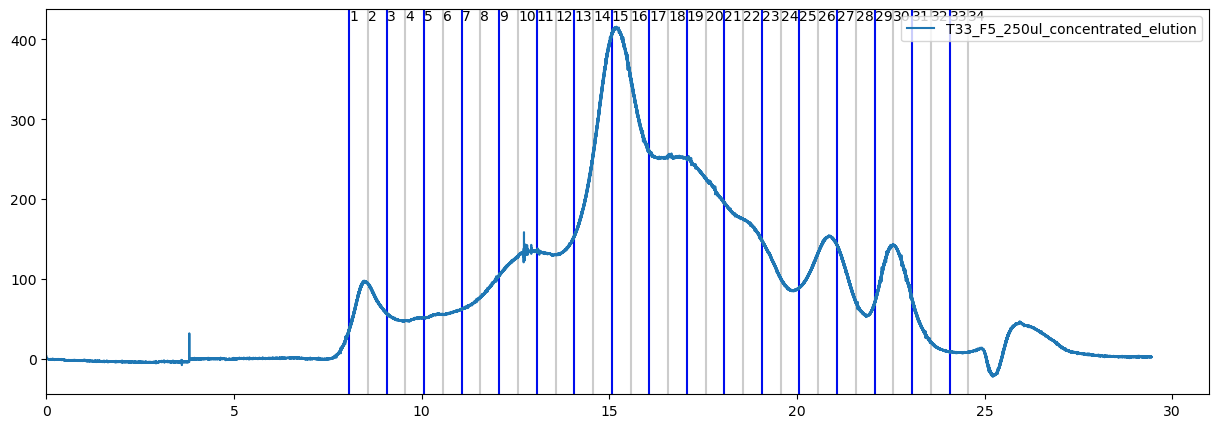

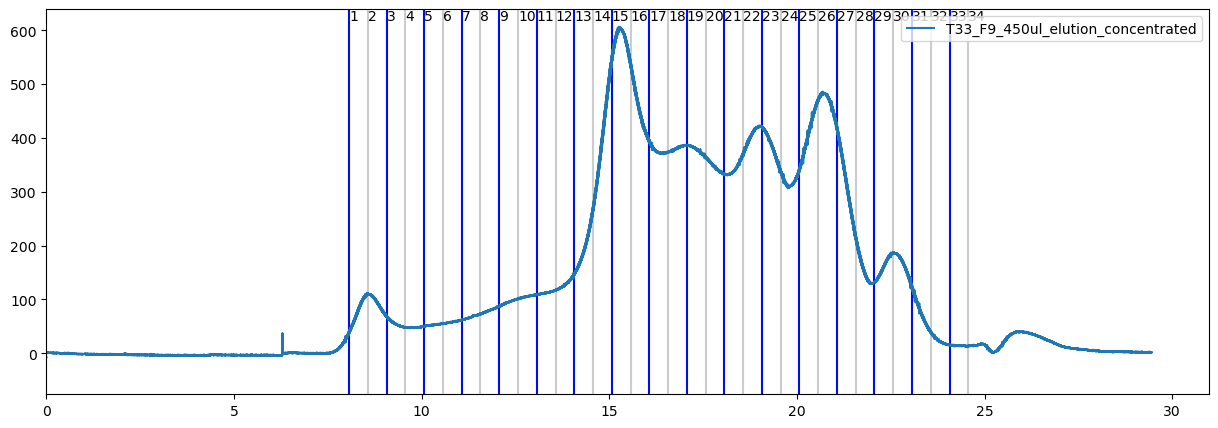

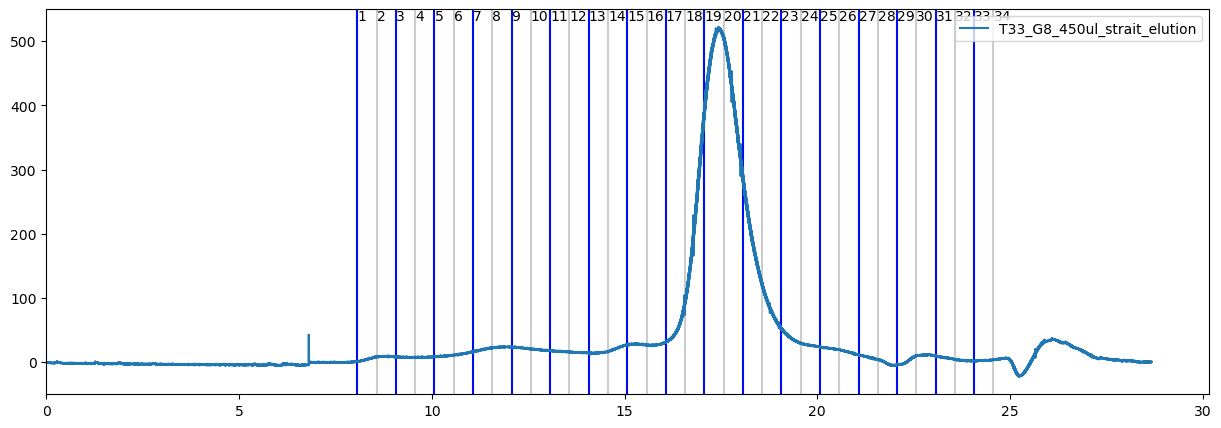

In [61]:
plot_chromatograms(sec_runs, only_280=only_plot_A280, 
                   overlap_chromatograms=overlap_chromatograms, stack_figures=stack_figures,
                   volume_is_column= not volume_is_index, fractions=plot_fractions,
                   fraction_start=fraction_start, fraction_end=fraction_end, fraction_size=fraction_size)

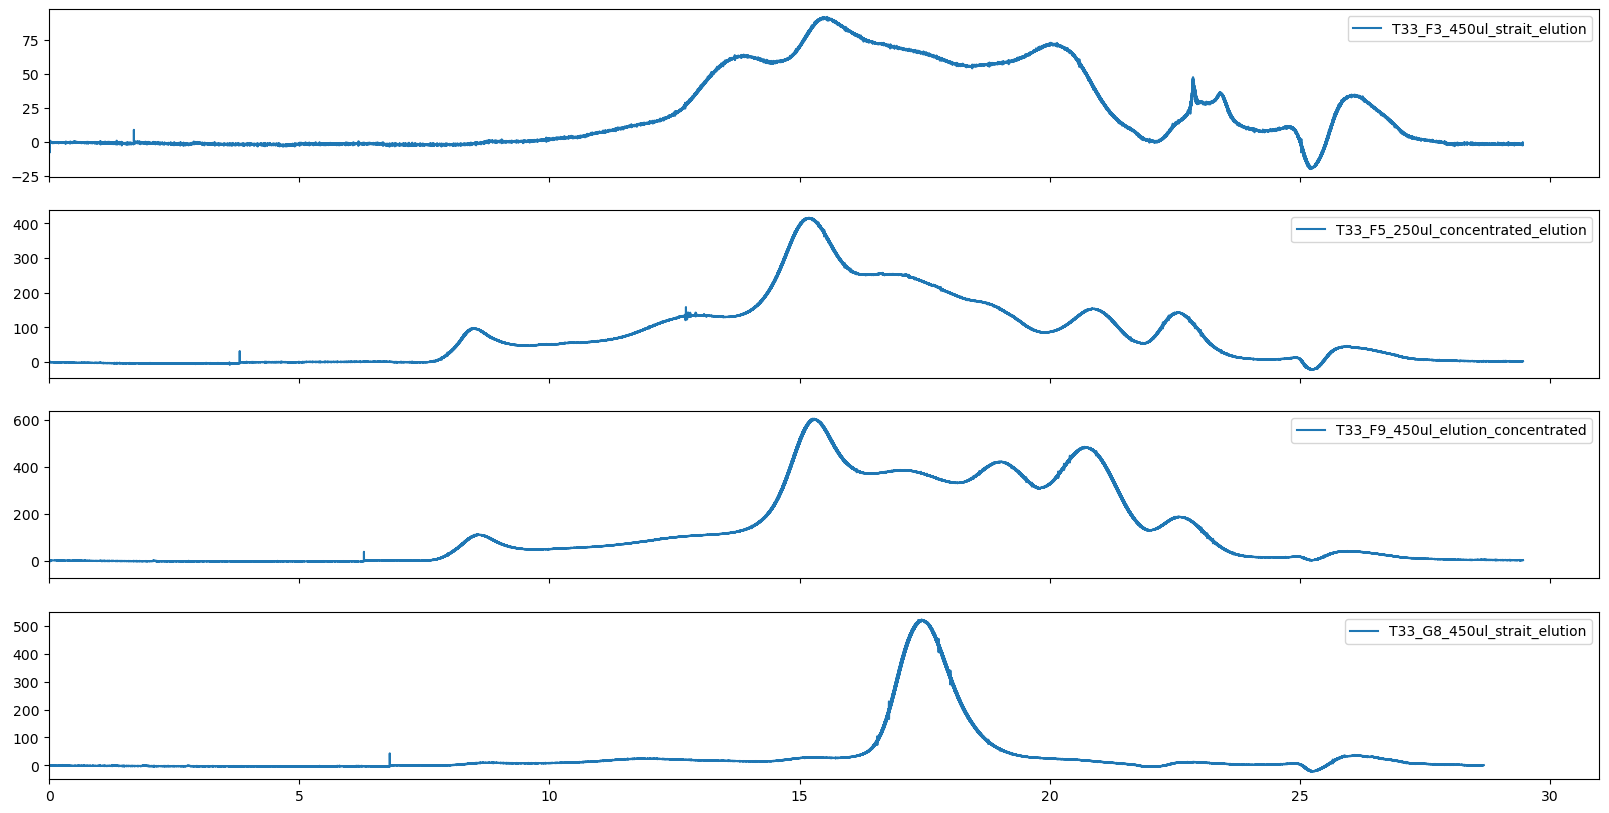

In [14]:
plot_chromatograms(sec_runs, only_280=only_plot_A280, volume_is_column= not volume_is_index)

In [15]:
figure_aspect_ratio = (10, 4)
fig = plt.figure(figsize=figure_aspect_ratio)
uv_ax = fig.subplots(1, 1)
uv_ax.plot(formatted_df, ) # label='Contact Order', color='#fbc0cb', lw=1, linestyle='-'

NameError: name 'formatted_df' is not defined

In [ ]:
fig.clear()